# TxMM 2020/21
## Final project code

S4752740

In [1]:
# Imports (a lot... a bit unorganized :S)

import sys
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime
import re

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from nltk import ngrams
from nltk import FreqDist

import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from multiprocessing import Pool, cpu_count
from functools import partial

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
tknzr = TweetTokenizer(preserve_case=True, reduce_len=False, strip_handles=True)


[nltk_data] Downloading package wordnet to /home/bart/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bart/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bart/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package tagsets to /home/bart/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bart/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loading the data

Useful link about the JSON structure of tweets: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/intro-to-tweet-json


We start with loading the JSON file into a list of tweets, where each tweet is a dictionary. Note that this can easily take 3GB of RAM, so make sure to close some Chrome tabs if you are low on RAM :P (or do some filtering beforehand)

In [2]:
def load_data(data_path):
    tweets = []
    with open(data_path) as fp:
        Lines = fp.readlines()
        for line in Lines:
            if len(line) > 1: # required for JSON decoder
                tweets.append( json.loads(line) )
    return tweets

path_to_data = "tweetsNinE3.json"
tweets = load_data(path_to_data)

Now we inspect how the data looks like:

In [3]:
# basic info on the data

print("Number of tweets:", str(len(tweets))) # we should have about 100.000 tweets
print()

# the tweets can have different attributes
print("Attributes of a random tweet:")
for key in tweets[36042].keys():
    print("-", key)

print()
# for this research, the most important ones are 'text' and 'created_at'/'timestamp_ms'
print("Example date (human readable):", tweets[36042]["created_at"])
print("Example date (ms since epoch, easier to parse):", tweets[36042]["timestamp_ms"])
print("Example text:", tweets[36042]["text"])

Number of tweets: 104695

Attributes of a random tweet:
- created_at
- id
- id_str
- text
- display_text_range
- source
- truncated
- in_reply_to_status_id
- in_reply_to_status_id_str
- in_reply_to_user_id
- in_reply_to_user_id_str
- in_reply_to_screen_name
- user
- geo
- coordinates
- place
- contributors
- is_quote_status
- quote_count
- reply_count
- retweet_count
- favorite_count
- entities
- extended_entities
- favorited
- retweeted
- possibly_sensitive
- filter_level
- lang
- timestamp_ms

Example date (human readable): Tue Jun 12 16:22:12 +0000 2018
Example date (ms since epoch, easier to parse): 1528820532207
Example text: Who's in the new Smash? #e3 #NintendoE3 https://t.co/uld4WNjZpK


To work a bit easier with the Tweets, we will load it into a pandas dataframe:

In [4]:
df = pd.DataFrame(tweets) # yes, this single line is all that it takes to load a list of dicts to a dataframe
print(df.shape)
print(df.columns)

(104695, 37)
Index(['created_at', 'id', 'id_str', 'text', 'source', 'truncated',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'quote_count', 'reply_count',
       'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted',
       'filter_level', 'lang', 'timestamp_ms', 'retweeted_status',
       'possibly_sensitive', 'extended_entities', 'display_text_range',
       'extended_tweet', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status', 'quoted_status_permalink', 'limit'],
      dtype='object')


As you can see, there are 37 different attributes for each tweet, though most have only 25 or so.
For now, we only want the 'text', 'id', 'user' and 'timestamp_ms'

In [5]:
df = df[['id', 'timestamp_ms', 'user', 'text']]
print(df.shape)
print(df.head())
print(df.columns)

(104695, 4)
             id   timestamp_ms  \
0  1.006567e+18  1528819224616   
1  1.006567e+18  1528819224688   
2  1.006567e+18  1528819224632   
3  1.006567e+18  1528819224735   
4  1.006567e+18  1528819224782   

                                                user  \
0  {'id': 782300925155237889, 'id_str': '78230092...   
1  {'id': 337267808, 'id_str': '337267808', 'name...   
2  {'id': 318781443, 'id_str': '318781443', 'name...   
3  {'id': 319243831, 'id_str': '319243831', 'name...   
4  {'id': 363245181, 'id_str': '363245181', 'name...   

                                                text  
0                        IT BEGINS!! #NintendoDirect  
1  RT @funkemcfly: lord forgive me but i'm back o...  
2  The Nintendo presentation is starting!!! My bo...  
3  RT @CelopanYT: VIENDO EL NINTENDO DIRECT CON V...  
4                          YO HERE WE GO #NintendoE3  
Index(['id', 'timestamp_ms', 'user', 'text'], dtype='object')


The user field was apparently nested with another dictionary, so we have to change it to the Twitter handle, which is the 'screen_name' field. We call this new column 'handle', and drop the 'user' column.

In [6]:
# look for the correct field
#print(df['user'][0]) 

# apparently some of the user values are not dicts, but floats, 
#  so we have to do some checking beforehand to prevent errors.
#  We replace invalid values by NaNs
df['handle'] = df.user.map(lambda x: x.get('screen_name', np.nan) \
                if isinstance(x, dict) and 'screen_name' in x else np.nan)

print(df['handle'])

df = df.drop(columns=['user'])

0         nickisonlinet
1          toochuckedup
2              C_Czar56
3          barbariuss98
4          WyattTheNerd
              ...      
104690        melinerpa
104691     greyredpanda
104692    Mumei_KujoYou
104693         Spiceona
104694       missduckie
Name: handle, Length: 104695, dtype: object


Lets inspect the result:

In [7]:
df.head()

,id,timestamp_ms,text,handle
0,1.006567e+18,1528819224616,IT BEGINS!! #NintendoDirect,nickisonlinet
1,1.006567e+18,1528819224688,RT @funkemcfly: lord forgive me but i'm back o...,toochuckedup
2,1.006567e+18,1528819224632,The Nintendo presentation is starting!!! My bo...,C_Czar56
3,1.006567e+18,1528819224735,RT @CelopanYT: VIENDO EL NINTENDO DIRECT CON V...,barbariuss98
4,1.006567e+18,1528819224782,YO HERE WE GO #NintendoE3,WyattTheNerd


## Cleaning the data
Now we want to do more preprocessing, like removing rows with NaN values, remove retweets, remove spam accounts, etc. Some of this code is from Assignment 1 to save some time.

In [8]:
# Remove rows with NaN values
rowsBefore = df.shape[0]
df = df.dropna()
rowsAfter = df.shape[0]

print("Removed", str(rowsBefore - rowsAfter), "rows with NaN values")

Removed 1254 rows with NaN values


In [9]:
retweets = df[df['text'].str[0:3] == "RT "].shape[0]
df = df[df['text'].str[0:3] != "RT "]
print("Removed", str(retweets), "retweets")

Removed 46313 retweets


In [10]:
dupes = df[df.duplicated(['text'])]
print("There are", str(dupes.shape[0]), "duplicates")
for dupe in dupes['text'].tolist()[150:200]:
    print(dupe)

There are 611 duplicates
Nintendo time! #E32018 #NintendoE3
SUPER MARIO PARTY #NintendoE3 #E32018
OH SHIT MARIO PARTY #NintendoE3
Mario Party!!! #NintendoE3
MARIO PARTY #NintendoE3 #E32018
MARIO PARTY #NintendoDirect
#NintendoE3 #E32018
Mario Party! #NintendoE3
#NintendoE3 let's go!
FIRE EMBLEM #NintendoE3
FIRE EMBLEM #NintendoE3 #E32018
Mario Party!!! #NintendoE3
Fire Emblem? #NintendoE3
FIRE EMBLEM #NintendoE3
Super Mario Party #E32018 #NintendoDirect
Fire Emblem? #NintendoE3
Super Mario Party! #NintendoE3
Fire Emblem? #NintendoE3
Fire Emblem! #NintendoE3
Fire Emblem? #NintendoE3
Super Mario Party!!! #NintendoE3
Fire Emblem! #NintendoE3
Fire Emblem! #NintendoE3
Fire Emblem? #NintendoE3
mario party!! #NintendoE3
FIRE EMBLEM #NintendoE3 #E32018
FIRE EMBLEM!!! #NintendoE3
MARIO PARTY!!! #NintendoE3
FIRE EMBLEM #NintendoE3
Fire Emblem!! #NintendoE3
FIRE EMBLEM!!! #NintendoE3
Super Mario Party. #NintendoE3
Mario Party is back #NintendoE3
FIRE EMBLEM!!! #NintendoE3
FIRE EMBLEM #NintendoE3


As you can see, there are only a few hundered duplicate tweets, where most of them are single word tweets or simple tweets where you would expect duplicates, like "Here we go!" (which is a Mario/Nintendo thing), and the name of the game that is announced. Therefore, I will keep them in the data.

Now lets look at spam:

Text(0, 0.5, 'Number of tweets')

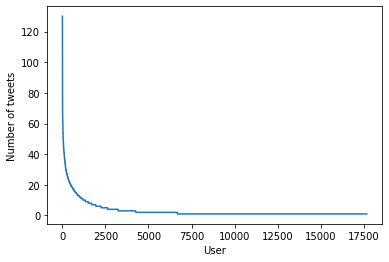

In [11]:
counts = df.handle.value_counts()
count_list = list(counts)
plt.plot(count_list)
plt.xlabel('User')
plt.ylabel('Number of tweets')

Text(0, 0.5, 'Number of users')

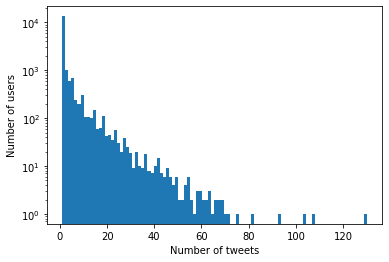

In [12]:
plt.hist(count_list, log=True, bins=100)
plt.xlabel('Number of tweets')
plt.ylabel('Number of users')

In [13]:
# List the 10 most frequent usernames
print(counts.nlargest(10))

# Print some of the tweets of each of the 5 most frequent usernames
most_frequent = counts.nlargest(5).to_dict()
# for each username in the set
for name in most_frequent.keys():
    # get a sample of the associated tweets and print
    sample = df[df.handle == name].text.sample(20)
    print(name)
    print(sample)

SansUT__           130
pastak             107
YouSpoonyBard1     104
schwagz124          93
FireStar891         81
kirbyboll427        75
MetaKnight57        71
NintenTuits         70
TheManlyStanley     69
yata_orangina       69
Name: handle, dtype: int64
SansUT__
69816             Available...December 7, 2018 #NintendoE3
56339                                Inklings. #NintendoE3
13951             Dude,t his looks good in HD. #NintendoE3
26763    FALLOUT SHELTER. DARK SOULS, WE HEARD THIS BEF...
58140         OH ASSIST TROPHIES FOR THOSE TWO #NintendoE3
69951                          And that's all? #NintendoE3
4205            Conference is really onpar lol #NintendoE3
55179                          New one? DAISY? #NintendoE3
37218                     dude that's TOO MUCH #NintendoE3
8197     What are they playing OOOOOH SUPER MARIO PARTY...
61750    too many stages? But are we limtied on em thou...
53709                             OOO NEW FACE #NintendoE3
57615                     

The most tweets a single user sent within the hour of the event using one of the two hashtags is 130. Upon further inspection on the tweets from top five most tweeting users, we can safely say that these users probably did not spam, but more likely tweeted every thought they had during the event using one of the hashtags. Therefore, we will not remove any of these tweets.

In [14]:
# after all cleaning, we are left with this many tweets:
print(df.shape[0])

57128


In [15]:
# removing urls
df['text'] = df['text'].apply(lambda x: re.sub(r"http\S+", "", str(x)))

## Time analysis
Here we will look at the times the tweets were sent:

In [16]:
# First we check if indeed the tweets were collected in the hour of the event
maxTime = int(df.timestamp_ms.max())
minTime = int(df.timestamp_ms.min())
timeSpan = maxTime - minTime
durationMinutes = timeSpan/60000

print("First Tweet: ", end='')
print(datetime.datetime.fromtimestamp(minTime/1000))

print("Last Tweet: ", end='')
print(datetime.datetime.fromtimestamp(maxTime/1000))

print("Duration in minutes: ", end='')
print(durationMinutes)

First Tweet: 2018-06-12 18:00:24.616000
Last Tweet: 2018-06-12 19:00:23.728000
Duration in minutes: 59.9852


As you can see, the start and end time corresponds to (though almost half a minute delayed) the time the event was held, which is 18:00 - 19:00 in Central European Standard Time (GMT+1).

## Annotation/Dataset selection

Here we look at the possibility of using emoticons and hashtags to assist with annotating the data.

In [17]:
# Lets look at how many tweets contain positive and negative smileys
posterms = [':-)', ':)', '=)', ':]', ':3', ':D', 'C:', 'c:', '☺️', '🙂', '😊', '😀', '😁', '😃', '😄', '😆', '😍', '❤️']
negterms = [':-(', ':(', '=(', ':c', ':[', 'D8', 'D;', 'D=', 'DX', 'v.v', 'T.T', '☹️', '🙁', '😠', '😡', '😞', '😟', '😣', '😖', '😵', '😕', '🤢', '💔', '😢', '😔']
posdf = df[df['text'].str.contains('|'.join(map(re.escape, posterms)))]
negdf = df[df['text'].str.contains('|'.join(map(re.escape, negterms)))]

print("using", len(posterms), "positive smileys")
print("using", len(negterms), "negative smileys")

print ("there are", posdf.shape[0], "Tweets with positive smileys")
print ("there are", negdf.shape[0], "Tweets with negative smileys")

display(posdf.head(10))
display(negdf.head(10))

# As you can see, there are lots of non-english tweets here.

using 18 positive smileys
using 25 negative smileys
there are 1203 Tweets with positive smileys
there are 364 Tweets with negative smileys


,id,timestamp_ms,text,handle
44,1.006567e+18,1528819226783,Goooooooo 😁😁😁😁😁 #nintendoE3,maella2011
173,1.006567e+18,1528819232402,#NintendoE3 let's do this! 😍,IshTehFish
395,1.006567e+18,1528819244831,Começou!! :D\n\n#nintendoDirect #E32018,meialuafsoco
451,1.006567e+18,1528819247750,Nintendo. Leggo! 😁 #NintendoE3 #E32018,NeioGio
493,1.006567e+18,1528819249446,#NintendoE3 is starting!! 😃🧐,LauraOfJakku
506,1.006567e+18,1528819249942,ES GEHT LOOOOOOS! 😍😍😍\nNintendo gibt alles!!! ...,MilanUnravel
624,1.006567e+18,1528819257487,Super excited 😭❤️❤️ #NintendoE3,_BloodyPirate
647,1.006567e+18,1528819258309,MECHA! Already hyped! :D #NintendoE3 #E32018,wolferey
648,1.006567e+18,1528819258321,HYPE! 😍\n\n#Nintendo #NintendoE3 #E32018,the_geru
654,1.006567e+18,1528819257540,👏Buenas tardes a tod@s y #FelizMartes 😀\n.\n.\...,furgonetascerca


,id,timestamp_ms,text,handle
743,1.006567e+18,1528819264713,Lets go! @iSirAnthony you're probs stuck at W...,JinseiIzon
805,1.006567e+18,1528819267644,YouTube app keeps thinking the video is over a...,kariohki
2255,1.006567e+18,1528819345609,#DaemonXmachina SOLD! (But not the music 🤢) #N...,That_Kid_Chris
3585,1.006568e+18,1528819401056,Flemme de regarder le #NintendoE3 j'avoue :(,Mangasmaniac
4472,1.006568e+18,1528819453649,Sentiment Analysis:\nLopetegui - 🙂\n#NintendoE...,FeelTheTweet_
4625,1.006568e+18,1528819460817,The #NintendoDirect can also watch on #DXP\nTh...,alamortiz92
5170,1.006568e+18,1528819482411,So... Much... Buffering... 😠#NintendoE3 #E32018,Spectre124
5310,1.006568e+18,1528819486733,Still stuck at work :( #NintendoDirect #Ninten...,Stickmansean
5454,1.006568e+18,1528819491301,Reggie a JAMAIS l'air naturel. CRISSE même en ...,LaurentLaSalle
6839,1.006568e+18,1528819547562,"Reggie, no me pierdas tiempo en cosas que ya s...",saulcastillo


In [18]:
# Lets look at the most ocurring hashtags
count_hashtags = df['text'].str.extractall(r'(\#\w+)')[0].value_counts()
count_hashtags.nlargest(50)

# As you can see here, all of the 50 most populair hashtags are neutral

#NintendoE3                39637
#E32018                    16648
#NintendoDirect            11364
#E3                         6181
#NintendoSwitch             1205
#SuperSmashBros             1111
#SmashBros                  1041
#e3                         1002
#nintendoe3                  802
#SuperSmashBrosUltimate      660
#SmashBrosSwitch             604
#Nintendo                    599
#e32018                      374
#SmashBrosUltimate           358
#nintendoE3                  338
#NintendoE32018              314
#NintendoDirectJP            285
#Fortnite                    271
#nintendodirect              237
#SuperMarioParty             209
#NINTENDOE3                  204
#FireEmblem                  193
#NintendoDirectE3            166
#Switch                      161
#SmashSwitch                 142
#E30218                      139
#MarioParty                  126
#XenobladeChronicles2        125
#Smash                       120
#PokemonLetsGo               105
#Overcooke

We can conclude from this that the use of hashtags is not useful, as they are only neutral. However, we could use emoticons, given that we manually go through all of them to remove the non-english ones.

In [19]:
# Uncomment these (code) lines to create files for manual annotation

# randomly sample tweets for manual neutral annotation
#neutraldf = df.sample(n=1000)

# replace newline by space for easier annotation
#neutraldf['text'] = neutraldf['text'].str.replace('\n',' ')
#posdf['text'] = posdf['text'].str.replace('\n',' ')
#negdf['text'] = negdf['text'].str.replace('\n',' ')

# print posdf and negdf to files, for manual annotation
#neutraldf['text'].to_csv('neutraldf.txt', sep='\t')
#posdf['text'].to_csv('posdf.txt', sep='\t')
#negdf['text'].to_csv('negdf.txt', sep='\t')

In [20]:
# Results of annotation: the IDs of the positive, negative and neutral tweets
DSpositiveIDs = [1525,1542,1680,1812,2353,3181,3318,4244,4487,4625,4662,4921,5063,5114,5132,5245,5279,5288,5318,5530,5546,5557,5614,5697,5784,5795,5997,6229,6282,6458,6478,6482,6550,6562,6738,6805,7088,7201,7412,7440,7445,7459,7526,7664,7670,7846,7908,8041,8136,8339,8576,8969,9127,9190,9314,9354,9360,9415,9630,9645,9716,10026,10278,10304,10351,10536,10665,10841,11154,11312,11356,11441,11489,11566,11579,11755,12002,12192,12194,12213,12410,12426,12507,12656,12783,12911,12947,13011,13023,13039,13173,13180,13269,13346,13352,13472,13618,13689,13705,13875,13999,14080,14234,14251,14303,14323,14348,14597,14686,14899,15262,15349,15424,15582,15747,16207,16257,16833,17138,17241,17394,18262,18753,18829,18831,19067,19198,19332,19467,19552,19558,19756,19776,19925,20054,20072,20203,20443,20448,20528,21145,21265,21629,21676,21714,21790,21888,21935,22216,22219,22247,22249,22463,22481,22928,22978,23007,23012,23253,23320,23450,23480,23735,23843,24032,24061,24110,24129,24262,24285,24393,24657,24874,24931,25349,25420,25597,25619,25723,25826,25887,25893,25913,25976,26139,26461,26499,26522,26638,26653,26693,26816,26824,26935,26979,27222,27269,27474,27760,27826,28115,28134,28352,28731,29080,29110,29354,29502,29694,30030,30159,31049,31169,31609,31673,31747,31764,31905,32002,32016,32065,32075,32149,32151,32253,32365,32410,32566,32574,32647,33656,34114,34304,34486,34549,34554,34740,34761,34762,34822,34966,35236,35615,35635,35761,35826,35897,36113,36313,36483,36569,36744,36757,36962,37021,37143,37526,37982,38097,38229,38261,38352,38353,38381,38422,38518,38787,39124,39462,39570,39639,39760,39773,40248,40431,40561,40785,41436,41473,41488,41558,41808,41948,41981,41986,42088,42112,42362,42412,42542,42843,42900,42941,42980,43119,43137,43148,43257,43753,43779,43856,43917,43967,44209,44268,44296,44397,44957,44959,45521,45837,45866,45881,46148,46319,46366,46446,46461,46995,47025,47045,47121,47424,47441,47657,47725,48056,48096,48141,48319,48373,48476,48560,48565,48773,48801,48880,48883,48907,49445,49467,49605,50353,50429,50720,50951,50969,50994,51316,51695,52307,52527,52575,52642,52785,52842,53078,53080,53098,53111,53129,53825,54099,54210,54999,55360,55507,55737,55907,56100,56145,56229,56262,56272,56397,56506,56560,56608,56669,56878,56900,56977,57016,57131,57144,57179,57237,57259,57710,57752,57999,58282,58463,58497,58644,58819,58966,59141,59264,59432,59526,59667,59928,59986,60850,60909,61110,61250,61502,61929,61931,62026,62464,62609,62617,62667,62787,62803,63003,63172,63866,64144,64471,64585,65000,65139,65499,65610,65855,66050,66218,66321,66682,67086,67964,68654,68824,69181,69279,69294,69430,70248,70501,70899,70901,70939,71033,71302,71365,71413,71430,71523,72052,72551,73116,73206,73265,73596,73639,73783,74212,75500,75609,76498,76703,76746,76932,77422,77516,77617,77873,78322,78455,78760,79710,80728,81120,82451,82655,82915,83334,83706,84423,85271,85969,86031,86175,86343,86625,86711,88517,88806,89850,90226,91004,91190,91263,93204,93475,93542,93863,94738,95289,97067,97570,100934,101789,102327,102764,103169,103361,103383,103991,104157]
DSnegativeIDs = [743,805,5170,5310,9572,10628,11586,12403,13132,13915,14351,15818,18966,19546,20008,20420,20906,21363,21756,21876,24984,26691,26857,30675,31069,32001,32509,33822,36147,36894,38405,38641,39067,39106,39886,40662,42331,42918,43702,43788,44235,44312,44612,44934,47598,48238,49713,49821,51272,51928,52743,53019,54324,58379,59075,59160,59221,59338,59393,59453,59554,59576,59924,59971,60263,60504,60568,60732,60940,61372,63219,64747,65014,65790,66634,67858,68202,70822,70887,71395,71400,71545,71784,72176,72220,72252,72365,72690,73154,73195,73296,73534,73635,73666,73895,74008,74234,74420,74441,74573,74996,75461,76535,76710,77127,77408,77560,77570,77854,78073,78169,79006,79052,79491,79540,79859,79957,80212,80662,80924,81190,82386,82957,83110,83846,84087,84575,84639,84816,86499,86993,87297,87374,87902,88017,88383,88882,89103,89824,90005,90735,91101,91609,92104,92387,92449,92487,92940,93040,93592,94387,95045,96088,96168,98552,98918,98970,101024,101643,101644,101954,101959,101983,102044,102490,102654,102911,103174,104401]
DSneutralIDs = [84814,22475,8493,70277,2884,76701,26082,57018,23524,71484,26229,14014,21031,19255,29716,91482,12486,21980,11443,10801,17983,47491,14735,18944,98060,4349,101336,18285,2266,62639,70776,56532,30952,25978,67622,53091,49498,11307,99743,1704,46587,52752,27355,92858,92250,29869,70904,44838,56858,68378,11554,23933,13306,41221,83239,54910,8668,10360,68031,22582,15753,10797,63220,10004,71219,4246,30475,29310,25104,55277,55281,11571,34065,44038,59979,15819,18284,7513,18282,12769,26914,36125,27432,70446,1738,74688,36926,16661,8826,17782,12688,34794,99406,5074,32374,5,5315,3136,25541,37920,24473,20354,16915,16722,8577]

DSpositive = df[df.index.isin(DSpositiveIDs)] 
DSnegative = df[df.index.isin(DSnegativeIDs)] 
DSneutral = df[df.index.isin(DSneutralIDs)] 

print("Positive tweets:", len(DSpositiveIDs))
display(DSpositive.sample(10))

print("Negative tweets:", len(DSnegativeIDs))
display(DSnegative.sample(10))

print("Neutral tweets:", len(DSneutralIDs))
display(DSneutral.sample(10))

Positive tweets: 514


,id,timestamp_ms,text,handle
4625,1.006568e+18,1528819460817,The #NintendoDirect can also watch on #DXP\nTh...,alamortiz92
62787,1.006576e+18,1528821491369,GREAT PLATEAU TOWER YAAAAAAS! 😍 #E3 #NintendoE3,KennyCastafi
61502,1.006576e+18,1528821437328,The graphics difference😍#NintendoE3,quietdva
89850,1.006580e+18,1528822256581,So happy I still have mine.😍,_MrsMusic
13011,1.006569e+18,1528819755052,Mario Party. ❤️ #NintendoE3 #e3,Slam_Anthem
77873,1.006578e+18,1528821950961,yoooo sooo much has been revealed 😀😀😀#NintendoE3,Shining_Miracle
27760,1.006571e+18,1528820231972,Carcassonne and Fallout Shelter 😍 #NintendoE3 ...,DariaMcKormick
21265,1.006570e+18,1528819994625,Overcook 2 😍😘 #E32018 #NintendoE3,leon_mont3r
15582,1.006569e+18,1528819838953,FIRe EMBlEm OMG 😍😍😍🤩🤩🤩 #NintendoE3,AlovesPokemon
32410,1.006572e+18,1528820405029,Ice Climbers are back! And the Inklings :D #Ni...,PeterVercetti


Negative tweets: 169


,id,timestamp_ms,text,handle
48238,1.006574e+18,1528820897580,#NintendoE3 So Castlevania and Metroid aren't ...,Duskbringer
60568,1.006576e+18,1528821400381,Bomberman pero es assist :( #NintendoDirect #E...,Diego_Saborio
67858,1.006577e+18,1528821708792,this isn't animal crossing &gt;:( #E3 #NintendoE3,doioresbunch
87297,1.006579e+18,1528822180227,Where's Metroid Prime 4 😢 #NintendoE3,migwelito
92487,1.006580e+18,1528822341230,Guess if you're a Smash fan you're happy. I ju...,xabbott
98970,1.006581e+18,1528822581717,I don’t like that Zelda and Sheik are still se...,ericschultheiss
98918,1.006581e+18,1528822580104,No @animalcrossing for Switch announced yet :(...,tmunikar
49713,1.006574e+18,1528820960895,Nintendo stop there's only so much I can take ...,plasmashad0w
93040,1.006580e+18,1528822359219,#NintendoE3 #E3 I just wanted an Animal Crossi...,thelastavengerr
92104,1.006580e+18,1528822328345,Waluigi is only a power up in Smash Bros. Ulti...,sandman420


Neutral tweets: 105


,id,timestamp_ms,text,handle
26082,1.006571e+18,1528820162705,"DBFZ Switch, huh.\n\n#NintendoE3 #E32018",SpottyLen
27432,1.006571e+18,1528820218925,Get your party on with Super Mario Party comin...,GeekVibesNation
23524,1.006570e+18,1528820063252,#HollowKnight along with all its DLC coming to...,Tipz22
54910,1.006575e+18,1528821194442,She ready for battle royal #E3 #NintendoE3,sjohyenar
37920,1.006573e+18,1528820582290,Smash Bros Ultimate with an insane amount of c...,joseph2411
12688,1.006569e+18,1528819746014,#SuperMarioParty is coming October 5th #Ninten...,ImdurC
10797,1.006569e+18,1528819689840,#NintendoE3\nIs this actual Mario Party?!,Simon_Apple11
71484,1.006578e+18,1528821818844,Reality has surpassed the meme. It's no longer...,Ductos
18282,1.006570e+18,1528819909087,#GSE32018 #NintendoE3 #Fortnite is coming to t...,dragonkaje
55277,1.006575e+18,1528821210149,CLONES ARE NOW OFFICALLY CALLED ECHO FIGHTERS#...,tingle_ebooks


In [21]:
DSpositive['label'] = 'Positive'
DSnegative['label'] = 'Negative'
DSneutral['label'] = 'Neutral'

# cut 150 positive, 50 negative and 30 neutral randomly selected tweets and put them in a test set
DSpositiveTest = DSpositive.sample(125)
DSnegativeTest = DSnegative.sample(50)
DSneutralTest = DSneutral.sample(30)

DSpositiveTrain = DSpositive[~DSpositive.index.isin(DSpositiveTest.index.to_list())]
DSnegativeTrain = DSnegative[~DSnegative.index.isin(DSnegativeTest.index.to_list())]
DSneutralTrain = DSneutral[~DSneutral.index.isin(DSneutralTest.index.to_list())]

In [22]:
DStrain = pd.concat([DSpositiveTrain, DSnegativeTrain, DSneutralTrain], ignore_index=True)
DStest = pd.concat([DSpositiveTest, DSnegativeTest, DSneutralTest], ignore_index=True)
display(DStrain)
print("Test set (do not look at it!) dimensions:", DStest.shape)

,id,timestamp_ms,text,handle,label
0,1.006567e+18,1528819307926,"Dunno what this is, but I'm liking the stylize...",FreezinIceKirby,Positive
1,1.006567e+18,1528819315852,This should be gooddddd 😍 #NintendoE3,DeGeabiIity,Positive
2,1.006567e+18,1528819323237,Awesome! :D #NintendoE3 #NintendoDirect #E3201...,SquirrelEmperor,Positive
3,1.006568e+18,1528819381794,Omg these leaked games look insane 😩😍 #Nintend...,wetheunicorns,Positive
4,1.006568e+18,1528819388324,"AY, XENOBLADE 😍 #NintendoE3",_Soria95,Positive
...,...,...,...,...,...
578,1.006580e+18,1528822333584,Nintendo occupying half the worldwide trends d...,juandocalrisian,Neutral
579,1.006580e+18,1528822353589,Is Fortnite on Switch Cross system or just for...,paulruk,Neutral
580,1.006581e+18,1528822598022,"With Ridley joining the game, I wonder if that...",JEFFBM,Neutral
581,1.006581e+18,1528822611559,I just tuned into #NintendoE3 announcing Ridle...,zarf,Neutral


Test set (do not look at it!) dimensions: (205, 5)


## Bigram vector creation

In [23]:

dftest = DStrain

def add_tokenized(tweet):
    token_list = tknzr.tokenize(tweet.text)
    token_list = [item.lower() for item in token_list]
    return token_list

dftest['tokenized'] = dftest.apply(add_tokenized, axis=1)

display(dftest)


def extract_ngram_freqs(token_list, n):
    grams = list(ngrams(token_list, n))
    cleaned_grams = []
    for word_tuple in grams:
        for word in word_tuple:
            if word not in stop_words:
                cleaned_grams.append(word_tuple)
                break
  
    return cleaned_grams


'''
A function to extract ngrams for every tweet in a frame. 
If not present, adds a column with the list of n-grams to the frame.
Its name is dependent on n.
'''
def extract_and_add_ngrams(frame, token_column, n):

    pool = Pool(cpu_count())
    extractor_func = partial(extract_ngram_freqs, n=n)
    list_of_grams = pool.map(extractor_func, list(dftest.tokenized))
    pool.close()

    # write to column
    name = 'grams' + str(n)
    if name not in frame.columns:
        dftest[name] = list_of_grams
    return name


# extracts the n-grams
column_name = extract_and_add_ngrams(dftest,'tokenized', n = 2)

#word_dist = FreqDist()
#for grams in dftest[column_name]:
#    word_dist.update(FreqDist(grams))
#print(f'Found {len(word_dist)} unique n-grams for n = {n}')

#most_common = word_dist.most_common(25)
#for word_tuple in most_common:
#    print(word_tuple)
    
display(dftest)

bigramVector = []
for bigramlist in dftest[column_name]:
    for bigram in bigramlist:
        if bigram not in bigramVector:
            bigramVector.append(bigram) 
        

,id,timestamp_ms,text,handle,label,tokenized
0,1.006567e+18,1528819307926,"Dunno what this is, but I'm liking the stylize...",FreezinIceKirby,Positive,"[dunno, what, this, is, ,, but, i'm, liking, t..."
1,1.006567e+18,1528819315852,This should be gooddddd 😍 #NintendoE3,DeGeabiIity,Positive,"[this, should, be, gooddddd, 😍, #nintendoe3]"
2,1.006567e+18,1528819323237,Awesome! :D #NintendoE3 #NintendoDirect #E3201...,SquirrelEmperor,Positive,"[awesome, !, :d, #nintendoe3, #nintendodirect,..."
3,1.006568e+18,1528819381794,Omg these leaked games look insane 😩😍 #Nintend...,wetheunicorns,Positive,"[omg, these, leaked, games, look, insane, 😩, 😍..."
4,1.006568e+18,1528819388324,"AY, XENOBLADE 😍 #NintendoE3",_Soria95,Positive,"[ay, ,, xenoblade, 😍, #nintendoe3]"
...,...,...,...,...,...,...
578,1.006580e+18,1528822333584,Nintendo occupying half the worldwide trends d...,juandocalrisian,Neutral,"[nintendo, occupying, half, the, worldwide, tr..."
579,1.006580e+18,1528822353589,Is Fortnite on Switch Cross system or just for...,paulruk,Neutral,"[is, fortnite, on, switch, cross, system, or, ..."
580,1.006581e+18,1528822598022,"With Ridley joining the game, I wonder if that...",JEFFBM,Neutral,"[with, ridley, joining, the, game, ,, i, wonde..."
581,1.006581e+18,1528822611559,I just tuned into #NintendoE3 announcing Ridle...,zarf,Neutral,"[i, just, tuned, into, #nintendoe3, announcing..."


,id,timestamp_ms,text,handle,label,tokenized,grams2
0,1.006567e+18,1528819307926,"Dunno what this is, but I'm liking the stylize...",FreezinIceKirby,Positive,"[dunno, what, this, is, ,, but, i'm, liking, t...","[(dunno, what), (is, ,), (,, but), (but, i'm),..."
1,1.006567e+18,1528819315852,This should be gooddddd 😍 #NintendoE3,DeGeabiIity,Positive,"[this, should, be, gooddddd, 😍, #nintendoe3]","[(be, gooddddd), (gooddddd, 😍), (😍, #nintendoe3)]"
2,1.006567e+18,1528819323237,Awesome! :D #NintendoE3 #NintendoDirect #E3201...,SquirrelEmperor,Positive,"[awesome, !, :d, #nintendoe3, #nintendodirect,...","[(awesome, !), (!, :d), (:d, #nintendoe3), (#n..."
3,1.006568e+18,1528819381794,Omg these leaked games look insane 😩😍 #Nintend...,wetheunicorns,Positive,"[omg, these, leaked, games, look, insane, 😩, 😍...","[(omg, these), (these, leaked), (leaked, games..."
4,1.006568e+18,1528819388324,"AY, XENOBLADE 😍 #NintendoE3",_Soria95,Positive,"[ay, ,, xenoblade, 😍, #nintendoe3]","[(ay, ,), (,, xenoblade), (xenoblade, 😍), (😍, ..."
...,...,...,...,...,...,...,...
578,1.006580e+18,1528822333584,Nintendo occupying half the worldwide trends d...,juandocalrisian,Neutral,"[nintendo, occupying, half, the, worldwide, tr...","[(nintendo, occupying), (occupying, half), (ha..."
579,1.006580e+18,1528822353589,Is Fortnite on Switch Cross system or just for...,paulruk,Neutral,"[is, fortnite, on, switch, cross, system, or, ...","[(is, fortnite), (fortnite, on), (on, switch),..."
580,1.006581e+18,1528822598022,"With Ridley joining the game, I wonder if that...",JEFFBM,Neutral,"[with, ridley, joining, the, game, ,, i, wonde...","[(with, ridley), (ridley, joining), (joining, ..."
581,1.006581e+18,1528822611559,I just tuned into #NintendoE3 announcing Ridle...,zarf,Neutral,"[i, just, tuned, into, #nintendoe3, announcing...","[(just, tuned), (tuned, into), (into, #nintend..."


## Features, classification and evaluation

In [24]:

# Classify using the features
def classifySVM(train_features, train_labels, test_features):
    clf = SVC(kernel='linear')
    clf.fit(train_features, train_labels)
    return clf.predict(test_features)

def classifyNB(train_features, train_labels, test_features):
    clf = GaussianNB()
    clf.fit(train_features, train_labels)
    return clf.predict(test_features)

In [25]:
# Evaluate predictions
def evaluate(y_true, y_pred):
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='macro')
    #print("Recall: %f" % recall)

    precision = sklearn.metrics.precision_score(y_true, y_pred, average='macro')
    #print("Precision: %f" % precision)

    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    #print("F1-score: %f" % f1_score)

    return recall, precision, f1_score

In [26]:
smileys = [':-)', ':)', '=)', ':]', ':3', ':D', 'C:', 'c:', '☺️', '🙂', '😊', '😀', '😁', '😃', '😄', '😆', '😍', '❤️', ':-(', ':(', '=(', ':c', ':[', 'D8', 'D;', 'D=', 'DX', 'v.v', 'T.T', '☹️', '🙁', '😠', '😡', '😞', '😟', '😣', '😖', '😵', '😕', '🤢', '💔', '😢', '😔']

def longestRepeating(s):
    maximum = 0
    count = 0
    current = ''
    for c in s:
        if c == current:
            count += 1
        else:
            count = 1
            current = c
        maximum = max(count,maximum)
    return maximum

In [27]:
# Extract features from a given df
# Should return a list of lists, which means a list of features for each row
# disableID can be used to disable a certain groups of features (for ablation testing)
def extract_features(df, disableID):
    allFeatures = []
    
    # FEATURE GROUPS (with ID for disabling):
    # 1) bigram
    # 2) document
    # 3) character
    # 4) smiley
    # 5) word
    # 6) pos
    
    # loop over each row
    for index, row in df.iterrows():
        features = []
        txt = row['text']
        
        bag_of_words = tknzr.tokenize(txt)
        
        POS = nltk.pos_tag(bag_of_words)
        
        bigrams = extract_ngram_freqs(bag_of_words, 2)
        
        
        # BIGRAM FEATURES
        if disableID != 1:
            # add occurrences of each bigram as a feature
            for g in bigramVector:
                features.append(bigrams.count(g))

        
        # DOCUMENT FEATURES
        if disableID != 2:
            # Total length of tweet
            features.append(len(txt))

            # Percentage of capitalized letters
            capitals = sum(1 for c in txt if c.isupper())
            features.append(capitals/len(txt))
        
        
        # CHARACTER FEATURES
        if disableID != 3:
            # Exclamation marks
            features.append(sum(1 for c in txt if c == '!'))
            # Question marks
            features.append(sum(1 for c in txt if c == '?'))
            # Dots
            features.append(sum(1 for c in txt if c == '.'))

            # Longest amount of repeating characters
            features.append(longestRepeating(txt))
        
        
        
        # SMILEY FEATURES
        if disableID == -1:
            for s in smileys:
                features.append(bag_of_words.count(s))
        
        
        
        # WORD FEATURES
        if disableID != 5:
            # Word count
            features.append(len(bag_of_words))

            # Word count, excluding stopwords
            features.append(len([x for x in bag_of_words if x.lower() not in stop_words]))

            # Number of unique words
            features.append(len(set(bag_of_words)))

            # Short word count
            features.append(len([x for x in bag_of_words if len(x) <= 3]))

            # Long word count
            features.append(len([x for x in bag_of_words if len(x) >= 10]))

            # All caps word count
            features.append(len([x for x in bag_of_words if x.isupper()]))

            # Average word length
            features.append(sum(len(x) for x in bag_of_words) / len(bag_of_words))

            # Number of duplicate words
            features.append(len(bag_of_words) - len(set(bag_of_words)))
        
        
        
        
        #POS FEATURES
        if disableID != 6:
            # POS tags (positivity)
            features.append(len([x for x in POS if x[1] == "VBN"]))
            features.append(len([x for x in POS if x[1] == "VBD"]))
            features.append(len([x for x in POS if x[1] == "WRB"]))
            features.append(len([x for x in POS if x[1] == "RB"]))
            features.append(len([x for x in POS if x[1] == "EX"]))

            # POS tags (negativity)
            features.append(len([x for x in POS if x[1] == "WP$"]))
            features.append(len([x for x in POS if x[1] == "RBS"]))
            features.append(len([x for x in POS if x[1] == "POS"]))
            features.append(len([x for x in POS if x[1] == "JJS"]))
            features.append(len([x for x in POS if x[1] == "NPS"]))

            # other POS tags
            features.append(len([x for x in POS if x[1] == "NN"]))
            features.append(len([x for x in POS if x[1] == "DT"]))
            features.append(len([x for x in POS if x[1] == "IN"]))
            features.append(len([x for x in POS if x[1] == "RB"]))
            features.append(len([x for x in POS if x[1] == "JJ"]))
            features.append(len([x for x in POS if x[1] == "VBZ"]))
            features.append(len([x for x in POS if x[1] == "CC"]))
            features.append(len([x for x in POS if x[1] == "NNP"]))
            features.append(len([x for x in POS if x[1] == "NNS"]))
            features.append(len([x for x in POS if x[1] == "PRP"]))
            features.append(len([x for x in POS if x[1] == "VB"]))
            features.append(len([x for x in POS if x[1] == "CD"]))
            features.append(len([x for x in POS if x[1] == "TO"]))
        
        
        # add features
        allFeatures.append(features)
    
    return allFeatures


def doSA(ignoreGroupID = 0):
    skf = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle = True)
    scoresSVM = []
    scoresNB = []
    for fold_id, (train_indexes, validation_indexes) in enumerate(skf.split(DStrain, DStrain.label)):
        # Print the fold number
        print("Fold %d" % (fold_id + 1))

        traindf = DStrain.iloc[train_indexes]
        valdf =  DStrain.iloc[validation_indexes]

        # Collect the data for this train/validation split
        train_features = extract_features(traindf, ignoreGroupID)
        train_labels = traindf.label.to_list()
        validation_features = extract_features(valdf, ignoreGroupID)
        validation_labels = valdf.label.to_list()


        # Classify and add the scores to be able to average later
        y_predSVM = classifySVM(train_features, train_labels, validation_features)
        y_predNB = classifyNB(train_features, train_labels, validation_features)
        scoresSVM.append(evaluate(validation_labels, y_predSVM))
        scoresNB.append(evaluate(validation_labels, y_predNB))

    # Print the averaged score
    recallSVM = sum([x[0] for x in scoresSVM]) / len(scoresSVM)
    #print("SVM: Averaged total recall", recall)
    precisionSVM = sum([x[1] for x in scoresSVM]) / len(scoresSVM)
    #print("SVM: Averaged total precision", precision)
    f_scoreSVM = sum([x[2] for x in scoresSVM]) / len(scoresSVM)
    #print("SVM: Averaged total f-score", f_score)
    #print("")

    recallNB = sum([x[0] for x in scoresNB]) / len(scoresNB)
    #print("NB: Averaged total recall", recall)
    precisionNB = sum([x[1] for x in scoresNB]) / len(scoresNB)
    #print("NB: Averaged total precision", precision)
    f_scoreNB = sum([x[2] for x in scoresNB]) / len(scoresNB)
    #print("NB: Averaged total f-score", f_score)
    #print("")
    
    return ((recallSVM, precisionSVM, f_scoreSVM), (recallNB, precisionNB, f_scoreNB))


#res = []
#for i in range (7):
#    res.append(doSA(i))


## Printing results

In [28]:
#print(res)

def ablationPlot():

    labels = ['No group', 'Bi-grams', 'Document', 'Character', 'Word', 'POS']
    SVM_f1 = [res[0][0][2], res[1][0][2], res[2][0][2], res[3][0][2], res[5][0][2], res[6][0][2]]
    NB_f1 = [res[0][1][2], res[1][1][2], res[2][1][2], res[3][1][2], res[5][1][2], res[6][1][2]]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, SVM_f1, width, label='SVM')
    rects2 = ax.bar(x + width/2, NB_f1, width, label='NB')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average F1-score')
    ax.set_title('Average F1-score for each missing feature group, no smiley features')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='lower right')

    fig.tight_layout()

    plt.show()

## Finally, check the score on the test set

In [29]:
def doTest():
    features = extract_features(DStrain, 0)
    
    test_features = extract_features(DStest, 0)
    
    y_predSVM = classifySVM(features, DStrain.label.to_list(), test_features)
    y_predNB = classifyNB(features, DStrain.label.to_list(), test_features)
    
    SVMtestScore = evaluate(DStest.label.to_list(), y_predSVM)
    NBtestScore = evaluate(DStest.label.to_list(), y_predNB)
    
    print(SVMtestScore, NBtestScore)

doTest()

# with smiley features:
# svm avg f1: 0.8865332769125555
# nb avg f1: 8339322894384074

# without smiley features:
# svm avg f1: 0.5875758352559173
# nb avg f1: 0.5756051610449994

(0.5573333333333333, 0.6743614488837418, 0.5875758352559173) (0.6244444444444445, 0.6373625517864374, 0.5756051610449994)
